# Run IPython Notebooks

In [2]:
%run get_stock_prices.ipynb

# Imports

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from datetime import datetime
from keras.preprocessing.sequence import TimeseriesGenerator
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.express as px

In [39]:
#ticker = input("Enter Ticker:").upper()
#ticker = "AAPL"

# Helper Functions

In [40]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [41]:
def predict(close_data, num_prediction, model,look_back):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x_list = prediction_list[-look_back:]
        xhat = x_list.reshape((1, look_back, 1))
        out = model.predict(xhat)[0][0]
        prediction_list = np.append(prediction_list, out)
        
    prediction_list = prediction_list[:look_back]
        
    return prediction_list

In [42]:
def predict_dates(close_data, num_prediction):
    last_date = close_data.index[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+5).tolist()
    weekdays = []
    for days in prediction_dates:
        if days.weekday() <5:
            weekdays.append(days)
    return weekdays

In [43]:
def train_test_split_70(X,y):
    
    split = int(0.7 * len(X))
    X_train = X[: split - 1]
    X_test = X[split:]
    y_train = y[: split - 1]
    y_test = y[split:]
    return X_train, X_test, y_train, y_test

In [44]:
def scale_X_y_data(X, y, X_train, X_test, y_train, y_test):
    scaler = MinMaxScaler()
    scaler.fit(X)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    scaler.fit(y)
    y_train = scaler.transform(y_train)
    y_test = scaler.transform(y_test)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    return X, y, X_train, X_test, y_train, y_test

In [2]:
def get_ml_model():
    # Window data
    window_size = 11
    feature_column = 0
    target_column = 0
    X, y = window_data(get_60d_df(ticker), window_size, feature_column, target_column)
    
    #Split Train test data by 70%
    X_train, X_test, y_train, y_test = train_test_split_70(X,y)
    
    #Scale X and Y Data
    scaler = MinMaxScaler()
    scaler.fit(X)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    scaler.fit(y)
    y_train = scaler.transform(y_train)
    y_test = scaler.transform(y_test)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    
    #Model Setup
    model = Sequential()
    # Initial model setup
    number_units = 30
    dropout_fraction = 0.2
    # Layer 1
    model.add(LSTM(
        units=number_units,
        return_sequences=True,
        input_shape=(X_train.shape[1], 1))
        )
    model.add(Dropout(dropout_fraction))

    # Layer 2
    model.add(LSTM(units=number_units, return_sequences=True))
    model.add(Dropout(dropout_fraction))

    # Layer 3
    model.add(LSTM(units=number_units))
    model.add(Dropout(dropout_fraction))

    # Output layer
    model.add(Dense(1))
    
    #Model Compile
    model.compile(optimizer="adam", loss="mean_squared_error")
    
    #Model Summary
    model_summary = model.summary()
    
    #Model Fit
    lstm_history = model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=90, verbose=1)
    
    #Model Evaluate
    model_evaluation = model.evaluate(X_test, y_test, verbose=0)
    
    #Model Predict
    predicted = model.predict(X_test)
    predicted_prices = scaler.inverse_transform(predicted)
    real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
    predicted_prices.shape
    stocks = pd.DataFrame({
        "Actual": real_prices.ravel(),
        "Predicted": predicted_prices.ravel()
    })
    ml_plot = px.line(stocks, title =f'Actual vs Predicted Prices of {ticker}')
    
    loss_plot = px.line(lstm_history.history["loss"])
    
    #Forecasting
    look_back=11
    
    forecast_ticker_df = get_60d_df(ticker)["Close"].values
    
    last_date = get_60d_df(ticker).index[-1]
    num_prediction = 11
    
    forecast = predict(forecast_ticker_df, num_prediction, model, look_back)
    forecast_dates = predict_dates(get_60d_df(ticker), num_prediction)
    forecast_series = pd.Series(forecast)
    forecast_dates_series = pd.Series(forecast_dates)
    forecast_df = pd.concat([forecast_series, forecast_dates_series],axis = 1)
    forecast_df = forecast_df.rename(columns = {0: "Price", 1:"Date"})
    forecast_df.set_index("Date",inplace=True)
    forecast_df.index = pd.to_datetime(forecast_df.index.date)
    forecast_plot = px.line(
        forecast_df,
        x = forecast_df.index,
        y=forecast_df["Price"],
        title =f'Forecast of {ticker}'
    )
    
    return model_evaluation, ml_plot, forecast_plot, loss_plot

In [46]:
# model_evaluation, ml_plot, forecast_plot, loss_plot = get_ml_model()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 11, 30)            3840      
_________________________________________________________________
dropout_9 (Dropout)          (None, 11, 30)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 11, 30)            7320      
_________________________________________________________________
dropout_10 (Dropout)         (None, 11, 30)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dropout_11 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

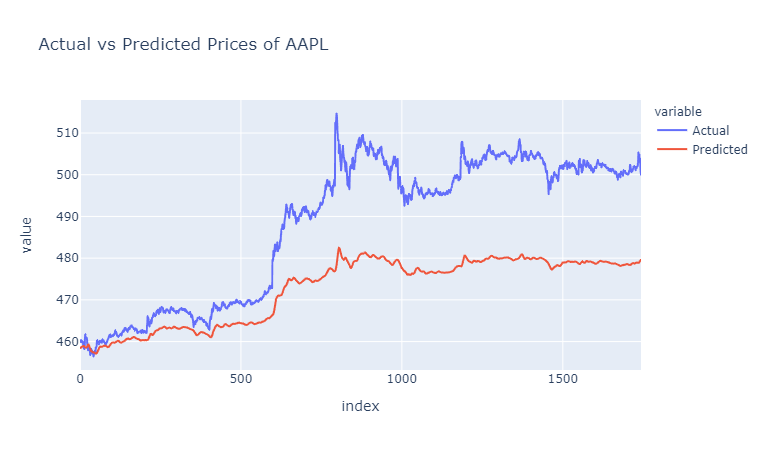

In [47]:
#ml_plot

In [2]:
#forecast_plot

In [64]:
#model_evaluation

0.0006835634703747928

In [1]:
#loss_plot